# 2a. Correct for bias, dark, and flat

Basic data reduction steps:

$$ R = \frac{(C-B)/t -D}{F} $$

- $R$: reduced count rate (counts/second)
- $C$: measured counts in the raw science exposure (counts)
- $B$: master bias (counts), from master bias (0 counts if not present)
- $t$: exposure time (seconds) of the science exposure
- $D$: dark current (counts/second), from master dark (0 counts/second if not present)
- $F$: flat field (arbitrary units, usually normalised to the median value), from master flat (1 if not present)

## Initialise parameters

In [1]:
import os  # to manipulate files and directories
import numpy as np  # mathematics
from astropy.io import fits  # FITS files
from matplotlib import pyplot as plt  # plotting

data_folder = '.'  # location of the observational data within your hard disk (by default, this directory)
calib_folder = os.path.join(data_folder, 'raw', 'calib')  # location of the master bias and dark
raw_flat_folder = os.path.join(calib_folder, 'flat')  # location of the master flats
raw_science_folder = os.path.join(data_folder, 'raw', 'science')  # location of the raw science exposures
output_folder = os.path.join(data_folder, 'reduced')  # name of the file where you intend to save the reduced exposures

## Read master bias, dark, and flats

In [2]:
filename = os.path.join(calib_folder, 'master_bias.fits')
if os.path.isfile(filename):
    print("Opening", filename)
    hdu = fits.open(filename)
    bias = hdu[0].data
else:
    print(filename, 'not found: set bias=0')
    bias = 0.

Opening ./raw/calib/master_bias.fits


In [3]:
filename = os.path.join(calib_folder, 'master_dark.fits')
if os.path.isfile(filename):
    print("Opening", filename)
    hdu = fits.open(filename)
    dark = hdu[0].data
else:
    print(filename, 'not found: set dark=0')
    dark = 0.

./raw/calib/master_dark.fits not found: set dark=0


In [4]:
flat = {}

for band in os.listdir(raw_flat_folder):  # Loop over all files in the directory
    band_folder = os.path.join(raw_flat_folder, band)
    if os.path.isdir(band_folder):
        filename = os.path.join(calib_folder, f'master_flat_{band}.fits')
        if os.path.isfile(filename):
            print("Opening", filename)
            hdu = fits.open(filename)
            flat[band] = hdu[0].data
        else:
            print(filename, 'not found: set flat=1')
            flat[band] = 1.

Opening ./raw/calib/master_flat_B.fits
Opening ./raw/calib/master_flat_V.fits


## Reduce individual science exposures

$$ R = \frac{(C-B)/t -D}{F} $$

TODO: combine different exposures (stacking)

Opening uamA_0025.fits


/tmp/ipykernel_7033/1116666875.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Opening uamA_0026.fits
Opening uamA_0023.fits
Opening uamA_0028.fits
Opening uamA_0024.fits
Opening uamA_0027.fits
Opening uamA_0031.fits
Opening uamA_0029.fits
Opening uamA_0030.fits
Opening uamA_0033.fits
Opening uamA_0032.fits


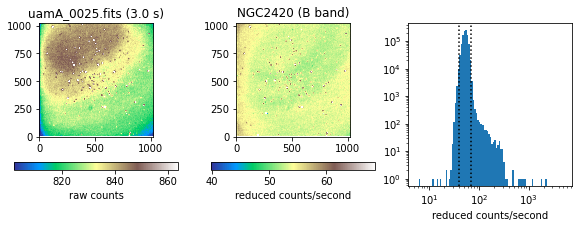

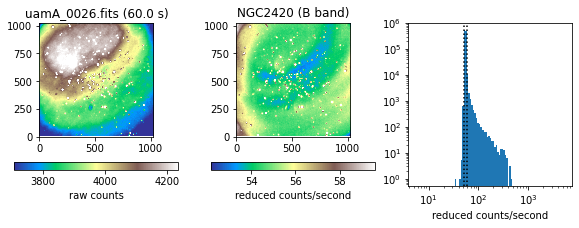

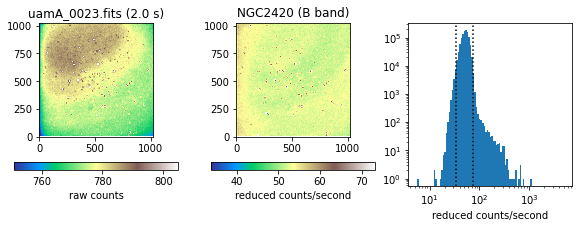

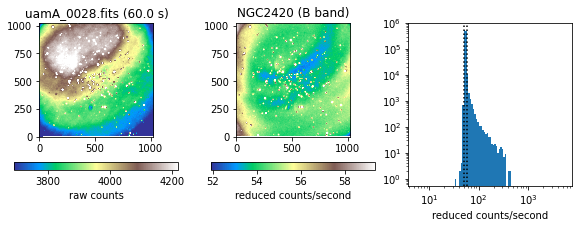

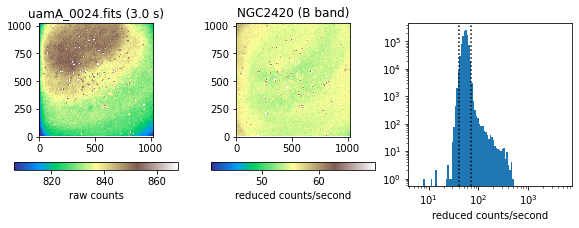

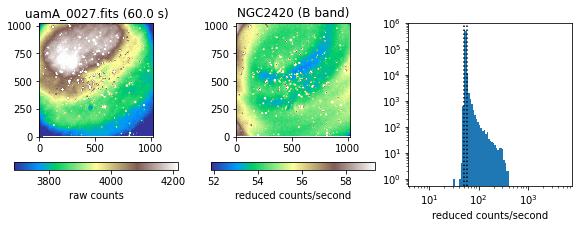

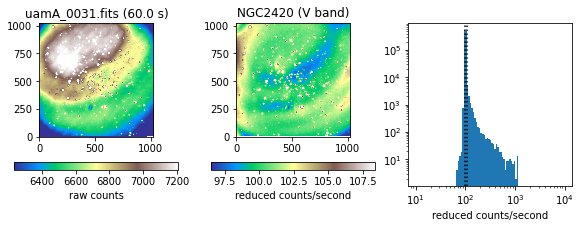

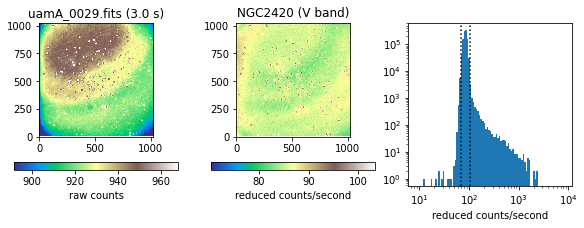

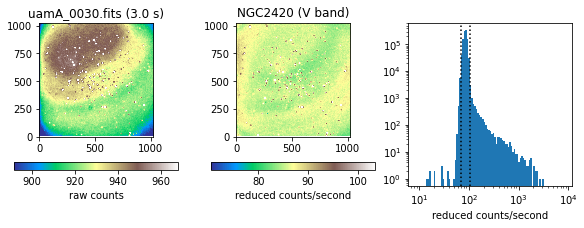

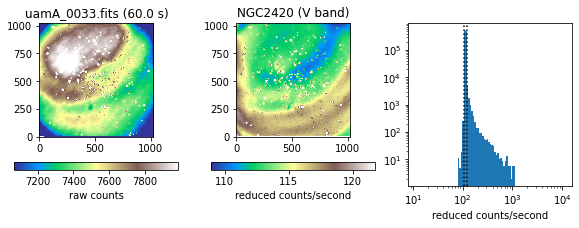

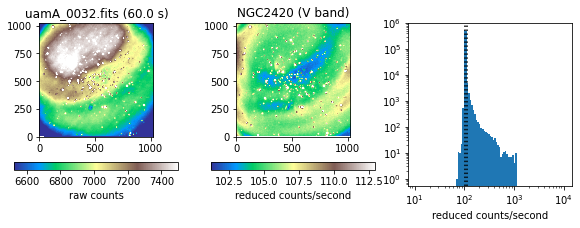

In [5]:
for object_name in os.listdir(raw_science_folder):  # Loop over all files in the directory
    object_folder = os.path.join(raw_science_folder, object_name)
    if os.path.isdir(object_folder):
        for band in os.listdir(object_folder):  # Loop over all files in the directory
            band_folder = os.path.join(object_folder, band)
            if os.path.isdir(band_folder):
                for filename in os.listdir(band_folder):  # Loop over all files in the directory
                    if os.path.splitext(filename)[1] == '.fits':  # FITS file extension
                        print("Opening", filename)
                        hdu = fits.open(os.path.join(band_folder, filename))  # HDU = Header/Data Unit (standard FITS nomenclature)
                        raw = hdu[0].data
                        reduced = ((raw - bias)/hdu[0].header['EXPTIME'] - dark) / flat[band]
                        
                        #hdu_out = fits.PrimaryHDU(reduced)
                        #hdu_out[0].header = hdu[0].header
                        output_filename = os.path.join(output_folder, object_name, band, filename)
                        fits.writeto(output_filename, reduced, hdu[0].header, overwrite=True)
                        
                        fig = plt.figure(figsize=(10, 3))
                        ax = fig.subplots(ncols=3)

                        ax[0].set_title(f'{filename} ({hdu[0].header["EXPTIME"]} s)')
                        im = ax[0].imshow(raw,
                                          origin='lower', vmin=np.nanpercentile(raw, 5), vmax=np.nanpercentile(raw, 95), cmap='terrain')
                        cb = fig.colorbar(im, ax=ax[0], orientation='horizontal')
                        cb.ax.set_xlabel('raw counts')
                        
                        ax[1].set_title(f'{object_name} ({band} band)')
                        im = ax[1].imshow(reduced,
                                          origin='lower', vmin=np.nanpercentile(reduced, 1), vmax=np.nanpercentile(reduced, 99), cmap='terrain')
                        cb = fig.colorbar(im, ax=ax[1], orientation='horizontal')
                        cb.ax.set_xlabel('reduced counts/second')
                        
                        xx = reduced[np.isfinite(reduced)].ravel()
                        ax[2].hist(xx, bins=np.logspace(np.log10(np.median(xx))-1, np.log10(np.median(xx))+2, 100))
                        ax[2].set_yscale('log')
                        ax[2].set_xscale('log')
                        ax[2].set_xlabel('reduced counts/second')
                        ax[2].axvline(np.nanpercentile(reduced, 1), c='k', ls=':')
                        ax[2].axvline(np.nanpercentile(reduced, 99), c='k', ls=':')
                        fig.show()